Step 3.1

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    balanced_accuracy_score,  # ← ADD THIS
    f1_score                   # ← ADD THIS
)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set paths
PROJECT_PATH = '/content/drive/MyDrive/UFC_ML_Project'
DATA_PROCESSED = f'{PROJECT_PATH}/data/processed'
MODELS_PATH = f'{PROJECT_PATH}/models'
VIZ_PATH = f'{PROJECT_PATH}/visualizations'

# Load feature-engineered data
data = pd.read_csv(f'{DATA_PROCESSED}/feature_engineered_data.csv')
print(f"✅ Loaded {len(data)} fights")

# Load feature list
with open(f'{DATA_PROCESSED}/feature_list.json', 'r') as f:
    feature_list = json.load(f)

all_features = feature_list['all_features']
print(f"✅ Loaded {len(all_features)} features")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded 4768 fights
✅ Loaded 39 features


Step 3.2

In [15]:
print("📊 Preparing train/test split with stratification...")

# Separate features and target
X = data[all_features].copy()
y = data['red_won'].copy()

# Handle missing values
X = X.fillna(X.median())

# TIME-BASED SPLIT: 2010-2019 train, 2020-2021 test
data['date'] = pd.to_datetime(data['date'])
split_date = pd.Timestamp('2020-01-01')

train_mask = data['date'] < split_date
test_mask = data['date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

train_dates = data[train_mask]['date']
test_dates = data[test_mask]['date']

print(f"✅ Data split complete!")
print(f"\n📊 Training set:")
print(f"   Size: {len(X_train)} fights")
print(f"   Date range: {train_dates.min()} to {train_dates.max()}")
print(f"   Red wins: {y_train.sum()} ({y_train.mean()*100:.1f}%)")
print(f"   Blue wins: {len(y_train) - y_train.sum()} ({(1-y_train.mean())*100:.1f}%)")

print(f"\n📊 Test set:")
print(f"   Size: {len(X_test)} fights")
print(f"   Date range: {test_dates.min()} to {test_dates.max()}")
print(f"   Red wins: {y_test.sum()} ({y_test.mean()*100:.1f}%)")
print(f"   Blue wins: {len(y_test) - y_test.sum()} ({(1-y_test.mean())*100:.1f}%)")

# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\n⚖️  Class weights (to handle imbalance):")
print(f"   Blue (0): {class_weight_dict[0]:.3f}")
print(f"   Red (1): {class_weight_dict[1]:.3f}")

# Calculate baseline
baseline_accuracy = max(y_test.mean(), 1 - y_test.mean())
print(f"\n🎯 Baseline (always predict majority): {baseline_accuracy*100:.1f}%")
print(f"   Target: Beat {baseline_accuracy*100:.1f}% to be useful!")

📊 Preparing train/test split with stratification...
✅ Data split complete!

📊 Training set:
   Size: 4196 fights
   Date range: 2010-01-02 00:00:00 to 2019-12-21 00:00:00
   Red wins: 2414 (57.5%)
   Blue wins: 1782 (42.5%)

📊 Test set:
   Size: 572 fights
   Date range: 2020-01-18 00:00:00 to 2021-03-20 00:00:00
   Red wins: 336 (58.7%)
   Blue wins: 236 (41.3%)

⚖️  Class weights (to handle imbalance):
   Blue (0): 1.177
   Red (1): 0.869

🎯 Baseline (always predict majority): 58.7%
   Target: Beat 58.7% to be useful!


Step 3.3A

In [16]:
print("🌳 Training BASELINE Decision Tree (for comparison)...")

# Simple baseline tree
dt_baseline = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_baseline.fit(X_train, y_train)

# Predictions
y_pred_dt_train = dt_baseline.predict(X_train)
y_pred_dt_test = dt_baseline.predict(X_test)
y_proba_dt_test = dt_baseline.predict_proba(X_test)[:, 1]

# Metrics
dt_train_acc = accuracy_score(y_train, y_pred_dt_train)
dt_test_acc = accuracy_score(y_test, y_pred_dt_test)
dt_auc = roc_auc_score(y_test, y_proba_dt_test)

print(f"\n✅ Baseline Decision Tree Results:")
print(f"   Training Accuracy: {dt_train_acc*100:.2f}%")
print(f"   Test Accuracy: {dt_test_acc*100:.2f}%")
print(f"   AUC-ROC: {dt_auc:.4f}")

# Check root feature
tree_structure = dt_baseline.tree_
root_feature = all_features[tree_structure.feature[0]]
print(f"\n🔍 Root feature chosen: {root_feature}")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_pred_dt_test, target_names=['Blue Wins', 'Red Wins']))

🌳 Training BASELINE Decision Tree (for comparison)...

✅ Baseline Decision Tree Results:
   Training Accuracy: 67.37%
   Test Accuracy: 55.94%
   AUC-ROC: 0.5655

🔍 Root feature chosen: diff_TD_landed

📊 Classification Report:
              precision    recall  f1-score   support

   Blue Wins       0.46      0.39      0.42       236
    Red Wins       0.61      0.68      0.64       336

    accuracy                           0.56       572
   macro avg       0.54      0.53      0.53       572
weighted avg       0.55      0.56      0.55       572



Step 3.3B

In [17]:
print("🔍 Analyzing feature correlations for custom ensemble...")

# Calculate correlations with target
feature_correlations = pd.DataFrame({
    'feature': all_features,
    'correlation': [X_train[feat].corr(y_train) for feat in all_features]
})
feature_correlations['abs_correlation'] = feature_correlations['correlation'].abs()
feature_correlations = feature_correlations.sort_values('abs_correlation', ascending=False)

# Top 10 features
top_10_features = feature_correlations.head(10)['feature'].tolist()

print(f"\n🎯 Top 10 Features by Correlation:")
print(feature_correlations.head(10)[['feature', 'correlation']].to_string(index=False))

# These will be prioritized in our custom ensemble
print(f"\n✅ Will build custom ensemble using these top features!")

🔍 Analyzing feature correlations for custom ensemble...

🎯 Top 10 Features by Correlation:
                feature  correlation
               elo_diff     0.099386
         diff_TD_landed     0.083692
          diff_win_rate     0.080085
 diff_control_dominance     0.072485
            elo_wc_diff     0.071344
        diff_td_defense     0.058020
    diff_strike_defense     0.057810
    diff_SIG_STR_landed     0.057405
diff_CTRL_time(seconds)     0.052556
             reach_diff     0.049278

✅ Will build custom ensemble using these top features!


Step 3.4

In [18]:
print("🎯 FIXED Custom Ensemble...")

# Simpler approach: Use ALL features but different random seeds
ensemble_trees_fixed = []
ensemble_predictions_test_fixed = []

for i in range(15):  # 15 trees
    tree = DecisionTreeClassifier(
        max_depth=12,
        min_samples_split=50,
        min_samples_leaf=25,
        class_weight='balanced',
        random_state=42 + i  # Different seed
    )

    # Each tree sees ALL features but different bootstrap sample
    sample_indices = np.random.RandomState(42+i).choice(
        len(X_train),
        size=int(0.8 * len(X_train)),
        replace=True
    )

    X_train_bootstrap = X_train.iloc[sample_indices]
    y_train_bootstrap = y_train.iloc[sample_indices]

    tree.fit(X_train_bootstrap, y_train_bootstrap)
    ensemble_trees_fixed.append(tree)
    ensemble_predictions_test_fixed.append(tree.predict(X_test))

# Majority vote
y_pred_ensemble_fixed = np.round(np.array(ensemble_predictions_test_fixed).mean(axis=0)).astype(int)
ensemble_fixed_acc = accuracy_score(y_test, y_pred_ensemble_fixed)

print(f"Fixed Ensemble Accuracy: {ensemble_fixed_acc*100:.2f}%")

🎯 FIXED Custom Ensemble...
Fixed Ensemble Accuracy: 54.90%


Step 3.5

In [19]:
print("="*80)
print("🌲 RANDOM FOREST: Proper implementation with feature diversity")
print("="*80)

# Train Random Forest with settings for maximum diversity
rf_model = RandomForestClassifier(
    n_estimators=100,           # 100 diverse trees
    max_depth=20,               # Allow deeper trees
    min_samples_split=30,       # Conservative splits
    min_samples_leaf=15,        # Substantial leaves
    max_features=10,            # Each tree sees 10 random features
    max_samples=0.7,            # Each tree trained on 70% of data
    class_weight='balanced',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

print(f"\n⚙️  Training 100 diverse decision trees...")
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)
y_proba_rf_test = rf_model.predict_proba(X_test)[:, 1]

# Metrics
rf_train_acc = accuracy_score(y_train, y_pred_rf_train)
rf_test_acc = accuracy_score(y_test, y_pred_rf_test)
rf_balanced_acc = balanced_accuracy_score(y_test, y_pred_rf_test)
rf_f1 = f1_score(y_test, y_pred_rf_test)
rf_auc = roc_auc_score(y_test, y_proba_rf_test)

print(f"\n✅ Random Forest Results:")
print(f"   Training Accuracy: {rf_train_acc*100:.2f}%")
print(f"   Test Accuracy: {rf_test_acc*100:.2f}%")
print(f"   Balanced Accuracy: {rf_balanced_acc*100:.2f}%")
print(f"   F1 Score: {rf_f1:.4f}")
print(f"   AUC-ROC: {rf_auc:.4f}")
print(f"\n   📈 Improvement over baseline DT: +{(rf_test_acc - dt_test_acc)*100:.2f}%")
print(f"   📈 Improvement over baseline: +{(rf_test_acc - baseline_accuracy)*100:.2f}%")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_pred_rf_test, target_names=['Blue Wins', 'Red Wins']))

# Analyze diversity
print(f"\n🔍 Analyzing Random Forest diversity...")
root_features_rf = []
for tree in rf_model.estimators_[:20]:  # Sample first 20 trees
    root_idx = tree.tree_.feature[0]
    root_features_rf.append(all_features[root_idx])

root_counts_rf = Counter(root_features_rf)
print(f"\n📊 Root features in first 20 trees:")
for feature, count in root_counts_rf.most_common(5):
    print(f"   {feature}: {count} trees")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 Top 10 Most Important Features (Random Forest):")
print(rf_feature_importance.head(10).to_string(index=False))

# Save
with open(f'{MODELS_PATH}/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
print(f"\n✅ Random Forest saved")

🌲 RANDOM FOREST: Proper implementation with feature diversity

⚙️  Training 100 diverse decision trees...

✅ Random Forest Results:
   Training Accuracy: 82.63%
   Test Accuracy: 56.99%
   Balanced Accuracy: 56.08%
   F1 Score: 0.6261
   AUC-ROC: 0.5993

   📈 Improvement over baseline DT: +1.05%
   📈 Improvement over baseline: +-1.75%

📊 Classification Report:
              precision    recall  f1-score   support

   Blue Wins       0.48      0.51      0.49       236
    Red Wins       0.64      0.61      0.63       336

    accuracy                           0.57       572
   macro avg       0.56      0.56      0.56       572
weighted avg       0.57      0.57      0.57       572


🔍 Analyzing Random Forest diversity...

📊 Root features in first 20 trees:
   diff_win_rate: 4 trees
   elo_diff: 4 trees
   diff_SIG_STR_pct: 3 trees
   diff_control_dominance: 3 trees
   elo_wc_diff: 2 trees

🔍 Top 10 Most Important Features (Random Forest):
                feature  importance
    diff_str

Step 3.6

In [20]:
print("="*80)
print("🚀 XGBOOST: Gradient boosting with class balancing")
print("="*80)

# Calculate scale_pos_weight
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=20,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)
y_proba_xgb_test = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
xgb_train_acc = accuracy_score(y_train, y_pred_xgb_train)
xgb_test_acc = accuracy_score(y_test, y_pred_xgb_test)
xgb_balanced_acc = balanced_accuracy_score(y_test, y_pred_xgb_test)
xgb_f1 = f1_score(y_test, y_pred_xgb_test)
xgb_auc = roc_auc_score(y_test, y_proba_xgb_test)

print(f"\n✅ XGBoost Results:")
print(f"   Training Accuracy: {xgb_train_acc*100:.2f}%")
print(f"   Test Accuracy: {xgb_test_acc*100:.2f}%")
print(f"   Balanced Accuracy: {xgb_balanced_acc*100:.2f}%")
print(f"   F1 Score: {xgb_f1:.4f}")
print(f"   AUC-ROC: {xgb_auc:.4f}")
print(f"\n   📈 Improvement over baseline: +{(xgb_test_acc - baseline_accuracy)*100:.2f}%")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_pred_xgb_test, target_names=['Blue Wins', 'Red Wins']))

# Feature importance
xgb_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔍 Top 10 Most Important Features (XGBoost):")
print(xgb_feature_importance.head(10).to_string(index=False))

# Save
with open(f'{MODELS_PATH}/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print(f"\n✅ XGBoost saved")

🚀 XGBOOST: Gradient boosting with class balancing

✅ XGBoost Results:
   Training Accuracy: 77.91%
   Test Accuracy: 57.52%
   Balanced Accuracy: 57.03%
   F1 Score: 0.6233
   AUC-ROC: 0.6083

   📈 Improvement over baseline: +-1.22%

📊 Classification Report:
              precision    recall  f1-score   support

   Blue Wins       0.49      0.54      0.51       236
    Red Wins       0.65      0.60      0.62       336

    accuracy                           0.58       572
   macro avg       0.57      0.57      0.57       572
weighted avg       0.58      0.58      0.58       572


🔍 Top 10 Most Important Features (XGBoost):
                  feature  importance
           diff_TD_landed    0.039595
                 elo_diff    0.038976
            diff_win_rate    0.036085
      diff_strike_defense    0.035820
weight_class_Bantamweight    0.034983
   weight_class_Flyweight    0.032089
               title_bout    0.031856
                diff_wins    0.031702
                  elo_avg  

Step 3.7

📊 COMPREHENSIVE MODEL COMPARISON

📊 Model Performance Summary:
          Model  Train Acc  Test Acc  Balanced Acc  AUC-ROC
    Baseline DT   0.673737  0.559441      0.534201 0.565470
Custom Ensemble   0.555767  0.500000      0.531527 0.600516
  Random Forest   0.826263  0.569930      0.560785 0.599324
        XGBoost   0.779075  0.575175      0.570294 0.608335

🏆 BEST MODEL: XGBoost
   Test Accuracy: 57.52%
   Balanced Accuracy: 57.03%
   AUC-ROC: 0.6083

✅ Saved comprehensive comparison to /content/drive/MyDrive/UFC_ML_Project/visualizations/model_comparison_all.png


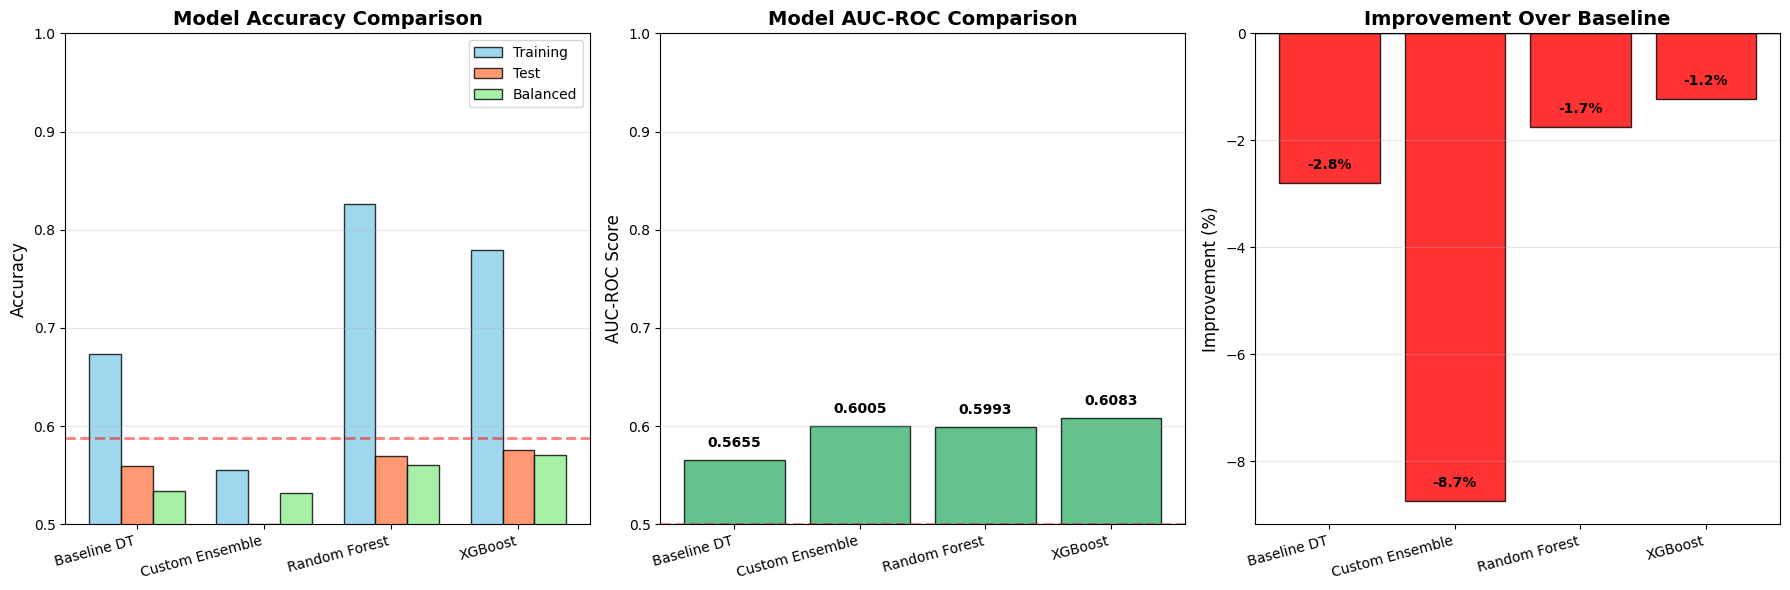

In [21]:
print("="*80)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*80)

# Compile results
models = ['Baseline DT', 'Custom Ensemble', 'Random Forest', 'XGBoost']
train_accuracies = [dt_train_acc, ensemble_train_acc, rf_train_acc, xgb_train_acc]
test_accuracies = [dt_test_acc, ensemble_test_acc, rf_test_acc, xgb_test_acc]
balanced_accuracies = [
    balanced_accuracy_score(y_test, y_pred_dt_test),
    ensemble_balanced_acc,
    rf_balanced_acc,
    xgb_balanced_acc
]
auc_scores = [dt_auc, ensemble_auc, rf_auc, xgb_auc]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Train Acc': train_accuracies,
    'Test Acc': test_accuracies,
    'Balanced Acc': balanced_accuracies,
    'AUC-ROC': auc_scores
})

print("\n📊 Model Performance Summary:")
print(comparison_df.to_string(index=False))

# Find best model
best_idx = np.argmax(test_accuracies)
best_model_name = models[best_idx]
best_accuracy = test_accuracies[best_idx]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_accuracy*100:.2f}%")
print(f"   Balanced Accuracy: {balanced_accuracies[best_idx]*100:.2f}%")
print(f"   AUC-ROC: {auc_scores[best_idx]:.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Accuracy comparison
x = np.arange(len(models))
width = 0.25

axes[0].bar(x - width, train_accuracies, width, label='Training', alpha=0.8, color='skyblue', edgecolor='black')
axes[0].bar(x, test_accuracies, width, label='Test', alpha=0.8, color='coral', edgecolor='black')
axes[0].bar(x + width, balanced_accuracies, width, label='Balanced', alpha=0.8, color='lightgreen', edgecolor='black')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim([0.5, 1.0])
axes[0].axhline(baseline_accuracy, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
axes[0].grid(True, alpha=0.3, axis='y')

# 2. AUC comparison
axes[1].bar(models, auc_scores, alpha=0.8, color='mediumseagreen', edgecolor='black')
axes[1].set_ylabel('AUC-ROC Score', fontsize=12)
axes[1].set_title('Model AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(models, rotation=15, ha='right')
axes[1].set_ylim([0.5, 1.0])
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

for i, auc in enumerate(auc_scores):
    axes[1].text(i, auc + 0.01, f'{auc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Improvement over baseline
improvements = [(acc - baseline_accuracy) * 100 for acc in test_accuracies]
colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
axes[2].bar(models, improvements, alpha=0.8, color=colors_imp, edgecolor='black')
axes[2].set_ylabel('Improvement (%)', fontsize=12)
axes[2].set_title('Improvement Over Baseline', fontsize=14, fontweight='bold')
axes[2].set_xticklabels(models, rotation=15, ha='right')
axes[2].axhline(0, color='black', linestyle='-', linewidth=1)
axes[2].grid(True, alpha=0.3, axis='y')

for i, imp in enumerate(improvements):
    axes[2].text(i, imp + 0.2, f'{imp:+.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/model_comparison_all.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved comprehensive comparison to {VIZ_PATH}/model_comparison_all.png")
plt.show()

Step 3.8

In [22]:
print("💾 Saving model metadata...")

# Compile all model results
model_metadata = {
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_info': {
        'total_fights': len(data),
        'training_fights': len(X_train),
        'test_fights': len(X_test),
        'train_date_range': [str(data[data.index.isin(X_train.index)]['date'].min()),
                             str(data[data.index.isin(X_train.index)]['date'].max())],
        'test_date_range': [str(data[data.index.isin(X_test.index)]['date'].min()),
                            str(data[data.index.isin(X_test.index)]['date'].max())],
        'features_count': len(all_features)
    },
    'models': {
        'baseline_decision_tree': {
            'train_accuracy': float(dt_train_acc),
            'test_accuracy': float(dt_test_acc),
            'auc_roc': float(dt_auc),
            'model_file': 'decision_tree_baseline.pkl'
        },
        'custom_ensemble': {
            'train_accuracy': float(ensemble_train_acc),
            'test_accuracy': float(ensemble_test_acc),
            'balanced_accuracy': float(ensemble_balanced_acc),
            'auc_roc': float(ensemble_auc),
            'n_trees': len(ensemble_trees),
            'model_file': 'custom_ensemble_model.pkl'
        },
        'random_forest': {
            'train_accuracy': float(rf_train_acc),
            'test_accuracy': float(rf_test_acc),
            'balanced_accuracy': float(rf_balanced_acc),
            'auc_roc': float(rf_auc),
            'model_file': 'random_forest_model.pkl'
        },
        'xgboost': {
            'train_accuracy': float(xgb_train_acc),
            'test_accuracy': float(xgb_test_acc),
            'balanced_accuracy': float(xgb_balanced_acc),
            'auc_roc': float(xgb_auc),
            'model_file': 'xgboost_model.pkl'
        }
    },
    'best_model': best_model_name.lower().replace(' ', '_'),
    'best_test_accuracy': float(best_accuracy),
    'baseline_accuracy': float(baseline_accuracy),
    'feature_list': all_features,
    'top_features': {
        'by_correlation': top_10_features,  # From Step 3.3.5
        'random_forest': rf_feature_importance.head(10)['feature'].tolist(),
        'xgboost': xgb_feature_importance.head(10)['feature'].tolist()
    }
}

# Save metadata
with open(f'{MODELS_PATH}/model_metadata.json', 'w') as f:
    json.dump(model_metadata, f, indent=2)

print(f"✅ Model metadata saved to {MODELS_PATH}/model_metadata.json")

# Print summary
print("\n" + "="*80)
print("MODEL TRAINING SUMMARY")
print("="*80)
print(f"Training Date: {model_metadata['training_date']}")
print(f"Total Fights: {model_metadata['dataset_info']['total_fights']}")
print(f"Features: {model_metadata['dataset_info']['features_count']}")
print(f"\n🏆 Best Model: {best_model_name.upper()}")
print(f"   Test Accuracy: {best_accuracy*100:.2f}%")
print(f"   Balanced Accuracy: {balanced_accuracies[best_idx]*100:.2f}%")
print(f"   AUC-ROC: {auc_scores[best_idx]:.4f}")
print(f"   Improvement over baseline: +{(best_accuracy - baseline_accuracy)*100:.2f}%")
print("="*80)

print(f"\n📊 All Models Performance:")
for model_name, test_acc in zip(models, test_accuracies):
    improvement = (test_acc - baseline_accuracy) * 100
    print(f"   {model_name:20s}: {test_acc*100:.2f}% ({improvement:+.2f}%)")

💾 Saving model metadata...
✅ Model metadata saved to /content/drive/MyDrive/UFC_ML_Project/models/model_metadata.json

MODEL TRAINING SUMMARY
Training Date: 2026-01-06 18:56:17
Total Fights: 4768
Features: 39

🏆 Best Model: XGBOOST
   Test Accuracy: 57.52%
   Balanced Accuracy: 57.03%
   AUC-ROC: 0.6083
   Improvement over baseline: +-1.22%

📊 All Models Performance:
   Baseline DT         : 55.94% (-2.80%)
   Custom Ensemble     : 50.00% (-8.74%)
   Random Forest       : 56.99% (-1.75%)
   XGBoost             : 57.52% (-1.22%)


Step 3.9

🎯 Analyzing prediction confidence...

📊 Accuracy by Prediction Confidence:
                mean  count
confidence                 
50-55%      0.524194    248
55-60%      0.526946    167
60-65%      0.663366    101
65-70%      0.750000     40
70-100%     0.875000     16

📊 Confidence Statistics:
   Min: 50.0%
   Max: 81.1%
   Mean: 57.2%
   Median: 56.2%
   Std Dev: 5.6%

📊 Predictions by Confidence Level:
   50-55%: 248 predictions (43.4%), Accuracy: 52.4%
   55-60%: 167 predictions (29.2%), Accuracy: 52.7%
   60-65%: 101 predictions (17.7%), Accuracy: 66.3%
   65-70%: 40 predictions (7.0%), Accuracy: 75.0%
   70-100%: 16 predictions (2.8%), Accuracy: 87.5%

✅ Saved prediction confidence analysis to /content/drive/MyDrive/UFC_ML_Project/visualizations/prediction_confidence.png


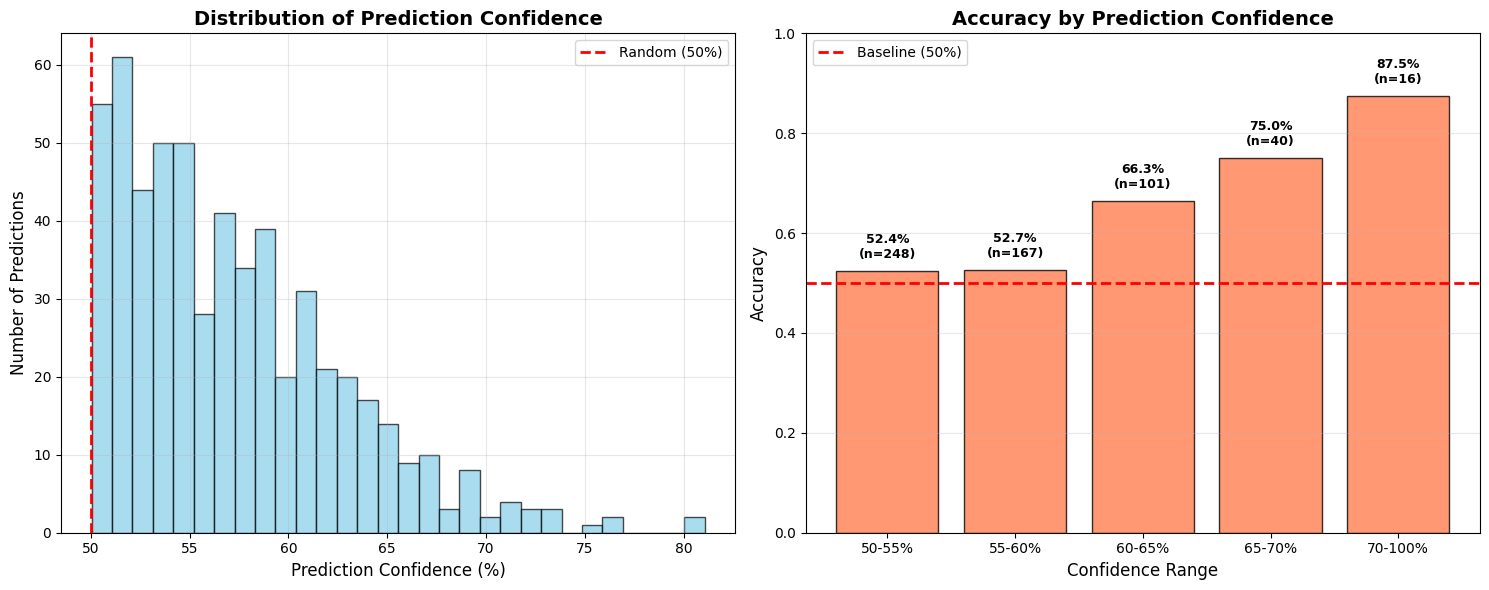


🎯 Higher Confidence Predictions (>60%):
   Count: 157 (27.4%)
   Accuracy: 70.7%

🎯 Medium Confidence Predictions (55-60%):
   Count: 167 (29.2%)
   Accuracy: 52.7%

📋 Sample Predictions with Confidence:
actual predicted  prob_red_wins  confidence correct
   Red       Red       0.810698    0.810698       ✅
  Blue      Blue       0.194964    0.805036       ✅
   Red       Red       0.769103    0.769103       ✅
  Blue      Blue       0.231248    0.768752       ✅
  Blue       Red       0.751480    0.751480       ❌
  Blue      Blue       0.266291    0.733709       ✅
   Red       Red       0.733458    0.733458       ✅
  Blue       Red       0.730386    0.730386       ❌
   Red       Red       0.726986    0.726986       ✅
   Red       Red       0.721961    0.721961       ✅


In [23]:
print("🎯 Analyzing prediction confidence...")

# Get prediction probabilities from best model (XGBoost)
y_proba_xgb = xgb_model.predict_proba(X_test)

# Calculate confidence (max probability)
confidence = np.max(y_proba_xgb, axis=1)

# Add to test data
test_results = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_xgb_test,
    'prob_red_wins': y_proba_xgb[:, 1],
    'prob_blue_wins': y_proba_xgb[:, 0],
    'confidence': confidence,  # Maximum probability (not difference!)
    'correct': (y_test.values == y_pred_xgb_test).astype(int)
})

# Analyze accuracy by confidence level
confidence_bins = pd.cut(test_results['confidence'],
                         bins=[0, 0.55, 0.60, 0.65, 0.70, 1.0],
                         labels=['50-55%', '55-60%', '60-65%', '65-70%', '70-100%'])
accuracy_by_confidence = test_results.groupby(confidence_bins)['correct'].agg(['mean', 'count'])

print("\n📊 Accuracy by Prediction Confidence:")
print(accuracy_by_confidence)

# Show confidence distribution
print(f"\n📊 Confidence Statistics:")
print(f"   Min: {confidence.min()*100:.1f}%")
print(f"   Max: {confidence.max()*100:.1f}%")
print(f"   Mean: {confidence.mean()*100:.1f}%")
print(f"   Median: {np.median(confidence)*100:.1f}%")
print(f"   Std Dev: {confidence.std()*100:.1f}%")

# Count by confidence level
print(f"\n📊 Predictions by Confidence Level:")
for label in ['50-55%', '55-60%', '60-65%', '65-70%', '70-100%']:
    count = (confidence_bins == label).sum()
    if count > 0:
        acc = test_results[confidence_bins == label]['correct'].mean()
        print(f"   {label}: {count} predictions ({count/len(test_results)*100:.1f}%), Accuracy: {acc*100:.1f}%")
    else:
        print(f"   {label}: 0 predictions (0.0%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confidence distribution
axes[0].hist(confidence*100, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(50, color='red', linestyle='--', linewidth=2, label='Random (50%)')
axes[0].set_xlabel('Prediction Confidence (%)', fontsize=12)
axes[0].set_ylabel('Number of Predictions', fontsize=12)
axes[0].set_title('Distribution of Prediction Confidence', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy by confidence (only show bins with data)
valid_bins = accuracy_by_confidence[accuracy_by_confidence['count'] > 0]
if len(valid_bins) > 0:
    axes[1].bar(range(len(valid_bins)), valid_bins['mean'],
                color='coral', alpha=0.8, edgecolor='black')
    axes[1].set_xticks(range(len(valid_bins)))
    axes[1].set_xticklabels(valid_bins.index, rotation=0)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_xlabel('Confidence Range', fontsize=12)
    axes[1].set_title('Accuracy by Prediction Confidence', fontsize=14, fontweight='bold')
    axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, label='Baseline (50%)')
    axes[1].set_ylim([0, 1])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels and sample size
    for i, (idx, row) in enumerate(valid_bins.iterrows()):
        axes[1].text(i, row['mean'] + 0.02,
                     f"{row['mean']*100:.1f}%\n(n={int(row['count'])})",
                     ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/prediction_confidence.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved prediction confidence analysis to {VIZ_PATH}/prediction_confidence.png")
plt.show()

# High confidence analysis (>60% instead of >70%)
print(f"\n🎯 Higher Confidence Predictions (>60%):")
high_confidence = test_results[test_results['confidence'] > 0.6]
if len(high_confidence) > 0:
    print(f"   Count: {len(high_confidence)} ({len(high_confidence)/len(test_results)*100:.1f}%)")
    print(f"   Accuracy: {high_confidence['correct'].mean()*100:.1f}%")
else:
    print(f"   Count: 0")
    print(f"   ⚠️  Model has no predictions above 60% confidence!")

# Medium confidence analysis (55-60%)
print(f"\n🎯 Medium Confidence Predictions (55-60%):")
medium_confidence = test_results[(test_results['confidence'] > 0.55) & (test_results['confidence'] <= 0.6)]
if len(medium_confidence) > 0:
    print(f"   Count: {len(medium_confidence)} ({len(medium_confidence)/len(test_results)*100:.1f}%)")
    print(f"   Accuracy: {medium_confidence['correct'].mean()*100:.1f}%")

# Show some examples
print(f"\n📋 Sample Predictions with Confidence:")
sample = test_results.nlargest(10, 'confidence')[['actual', 'predicted', 'prob_red_wins', 'confidence', 'correct']]
sample['actual'] = sample['actual'].map({0: 'Blue', 1: 'Red'})
sample['predicted'] = sample['predicted'].map({0: 'Blue', 1: 'Red'})
sample['correct'] = sample['correct'].map({0: '❌', 1: '✅'})
print(sample.to_string(index=False))

Visualization

📊 Creating comprehensive visualizations...

1️⃣ Decision Tree Structure...
   ✅ Saved: decision_tree_structure.png


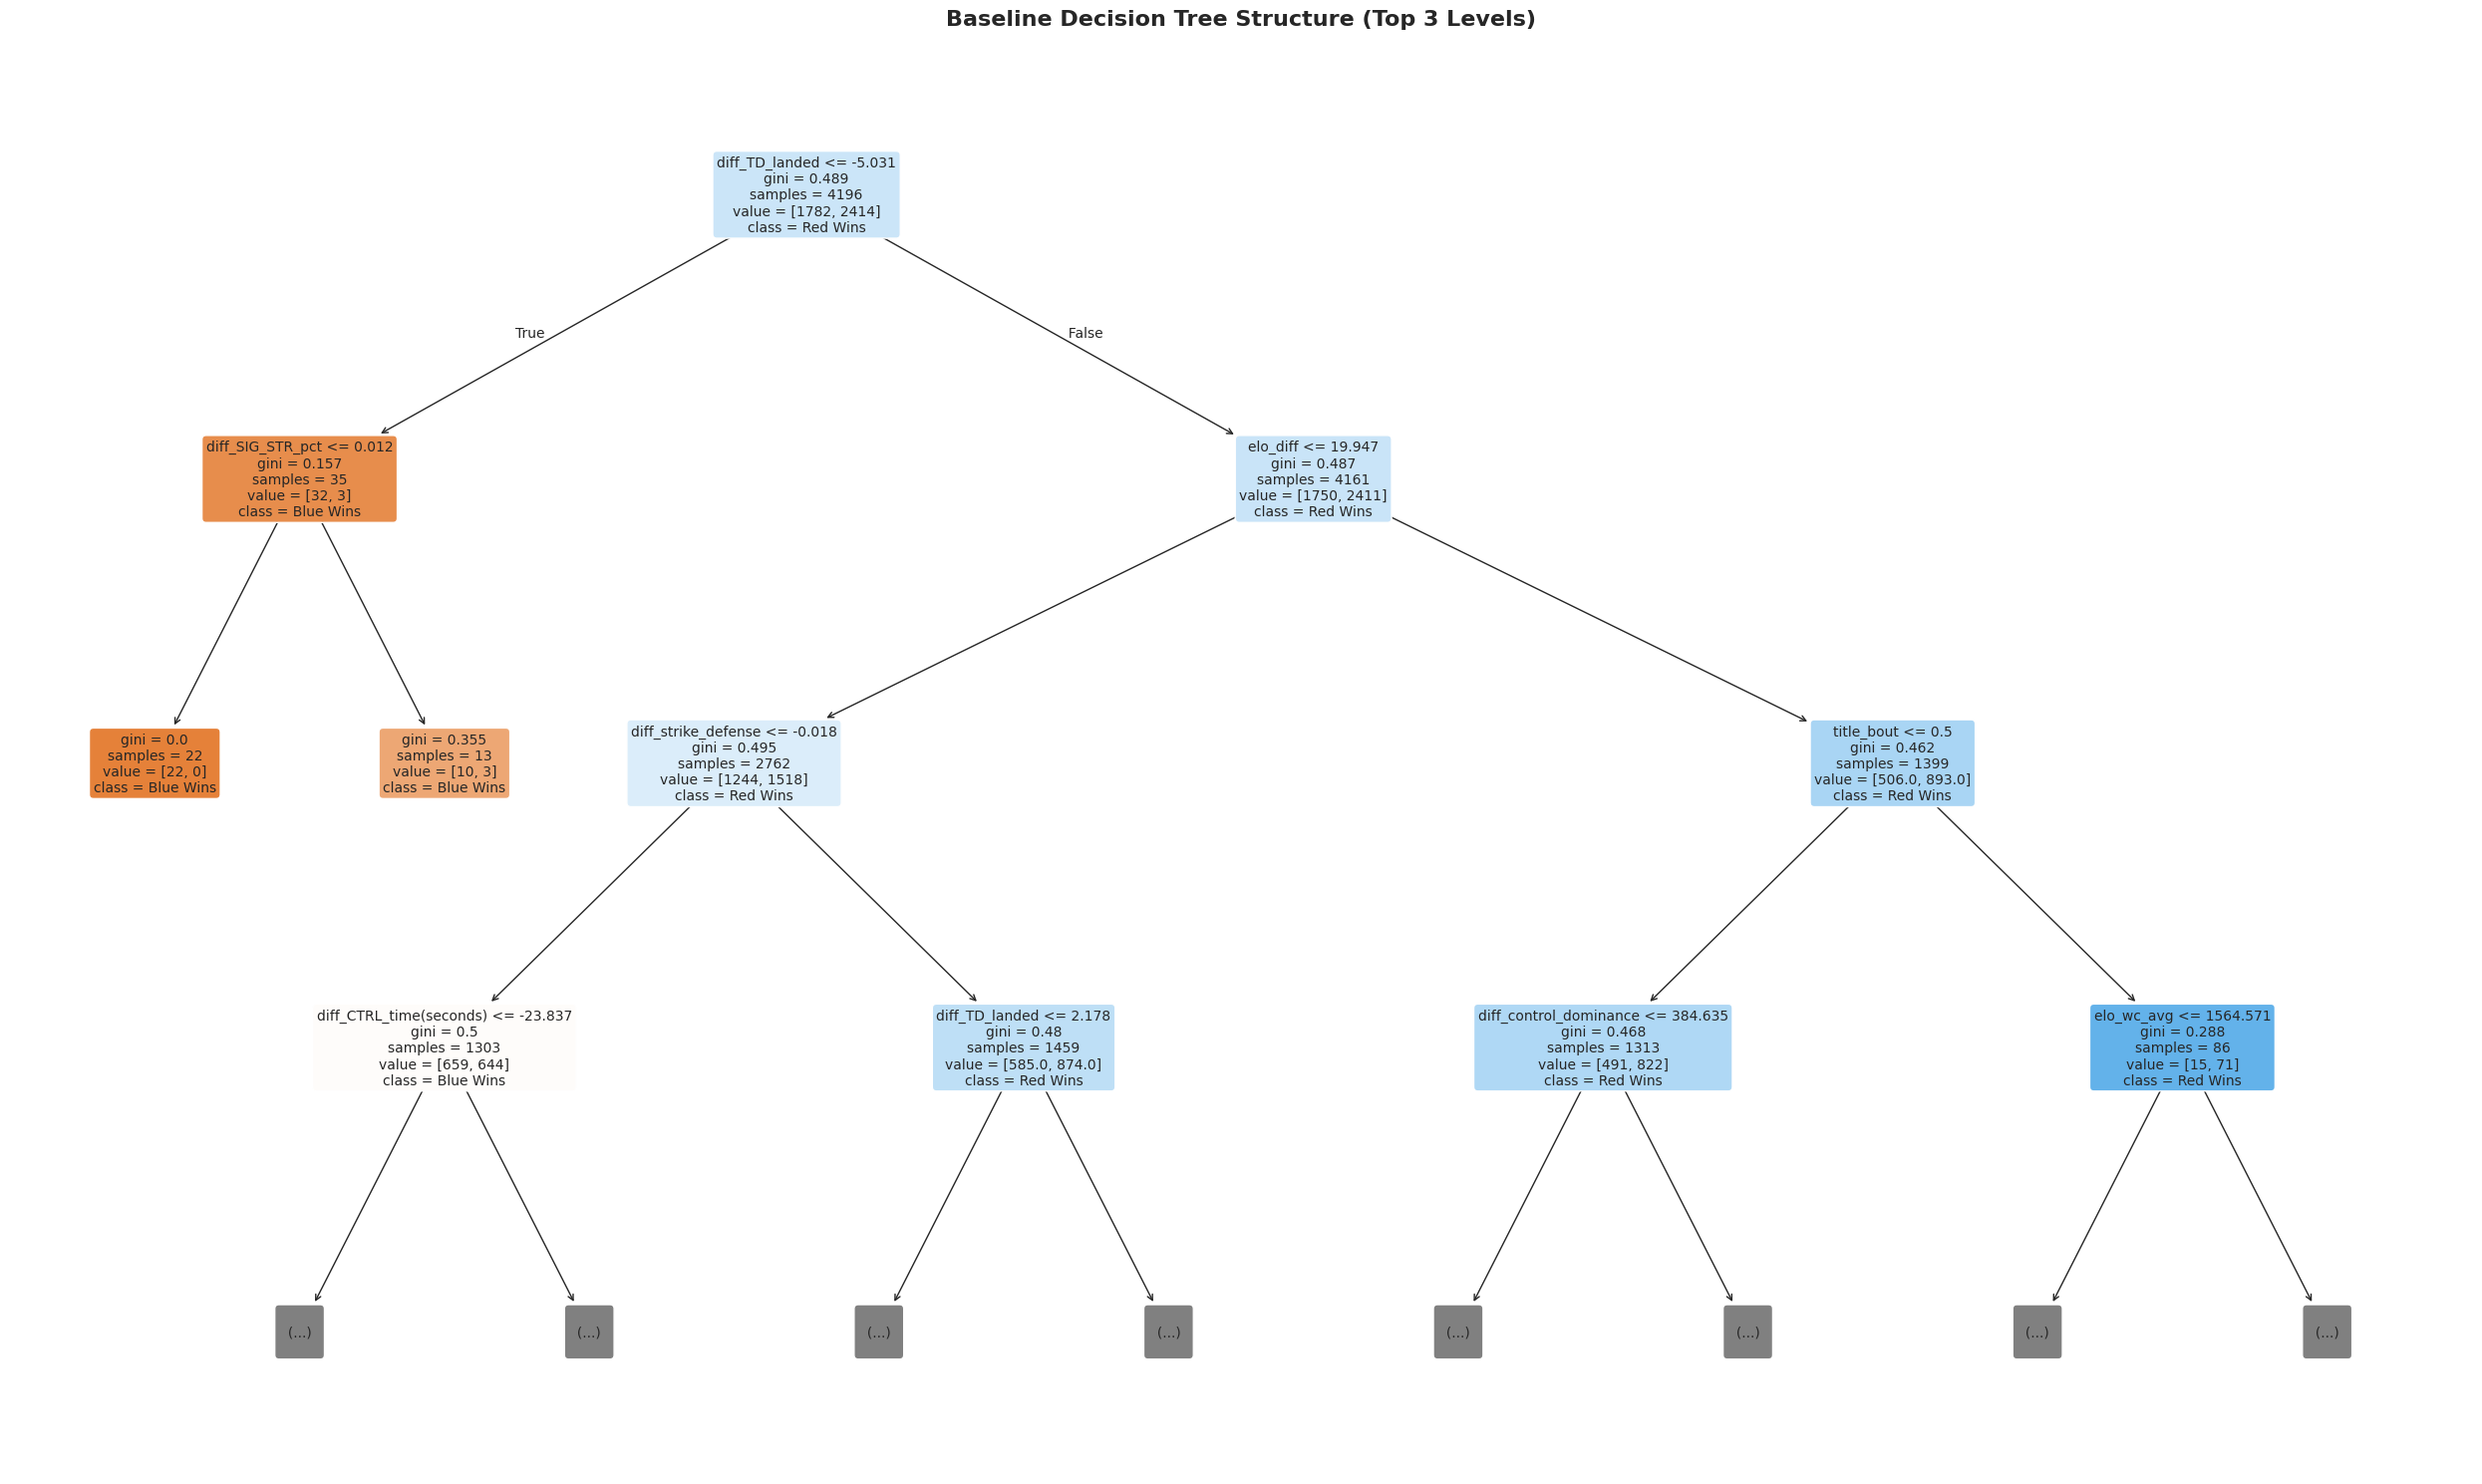


2️⃣ Feature Importance Across Models...
   ✅ Saved: feature_importance_comparison.html



3️⃣ Model Performance Dashboard...
   ✅ Saved: performance_dashboard.html



4️⃣ Prediction Analysis (XGBoost)...
   ✅ Saved: prediction_analysis.png


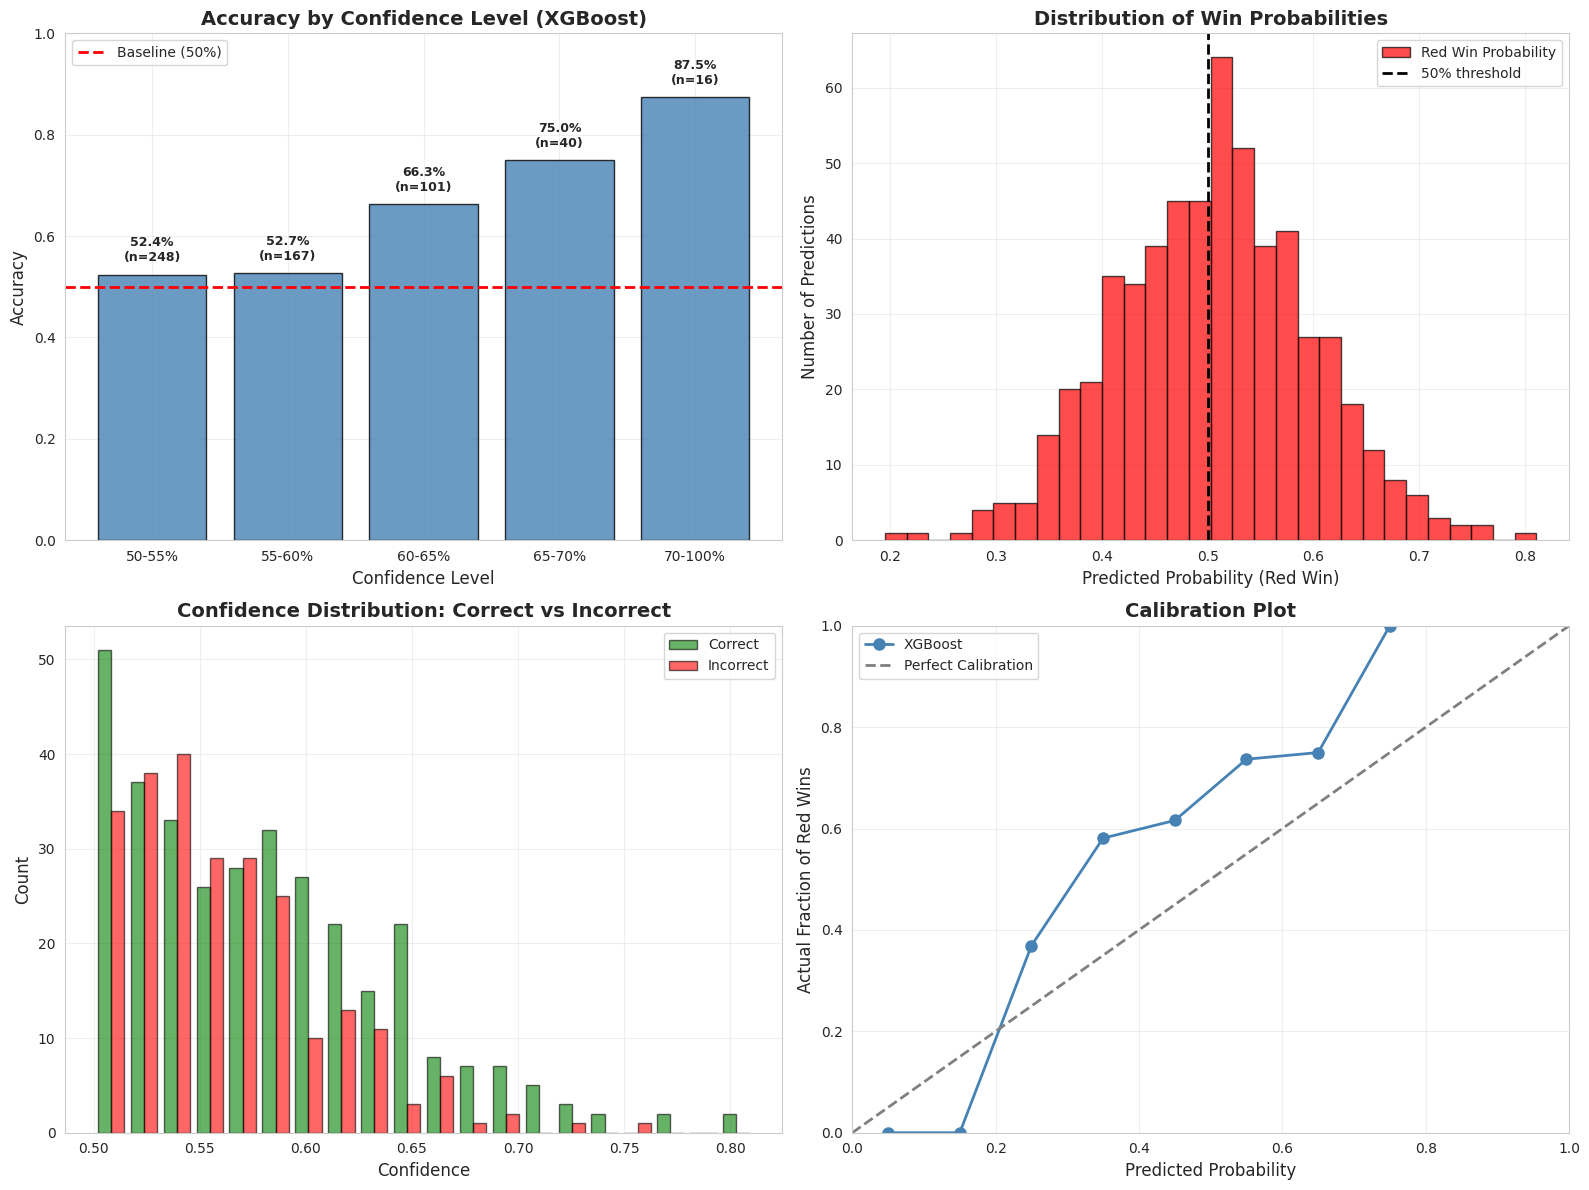


5️⃣ Feature Correlation Analysis...
   ✅ Saved: feature_correlation_heatmap.png


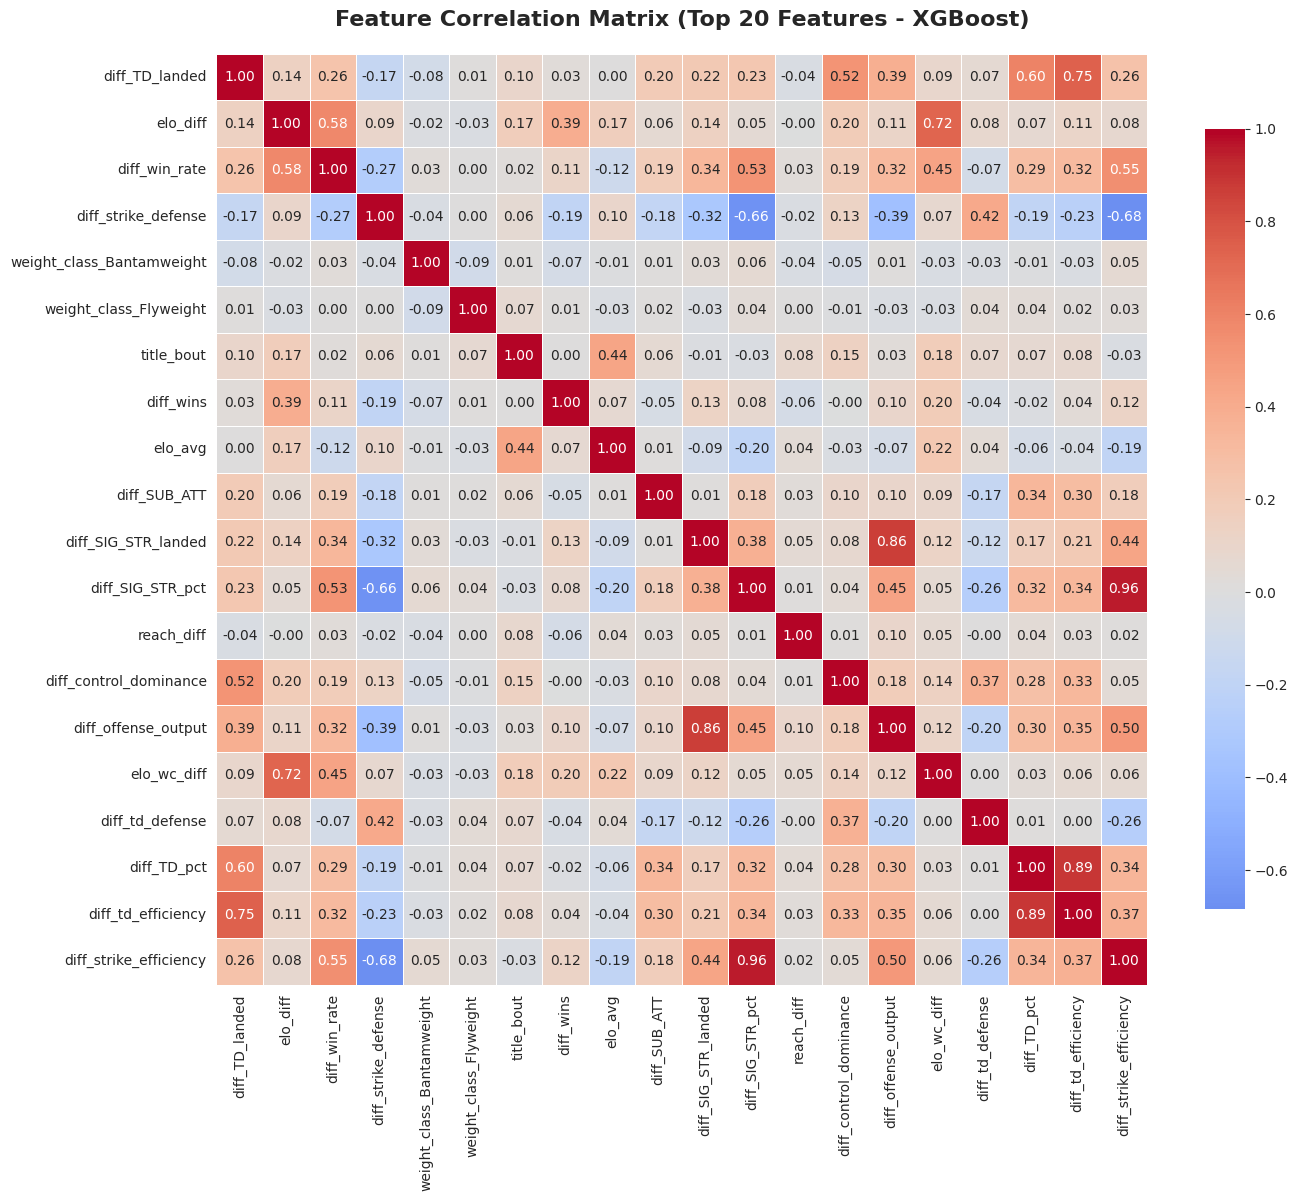


6️⃣ ELO Impact Analysis...
   ✅ Saved: elo_impact_analysis.png


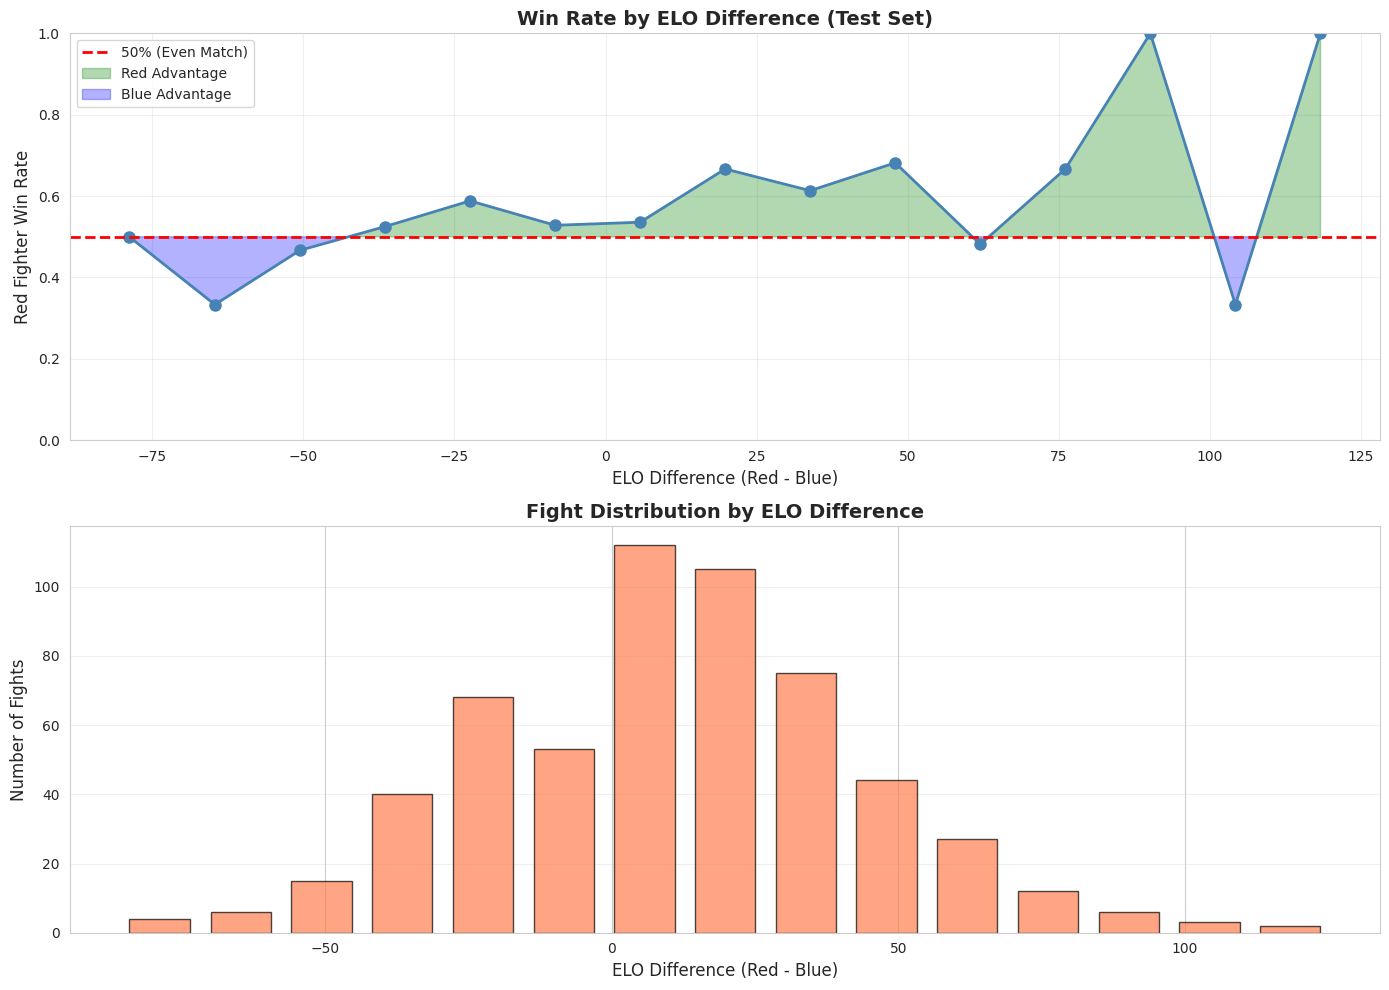


7️⃣ Creating Model Comparison Summary...
   ✅ Saved: model_summary_table.png


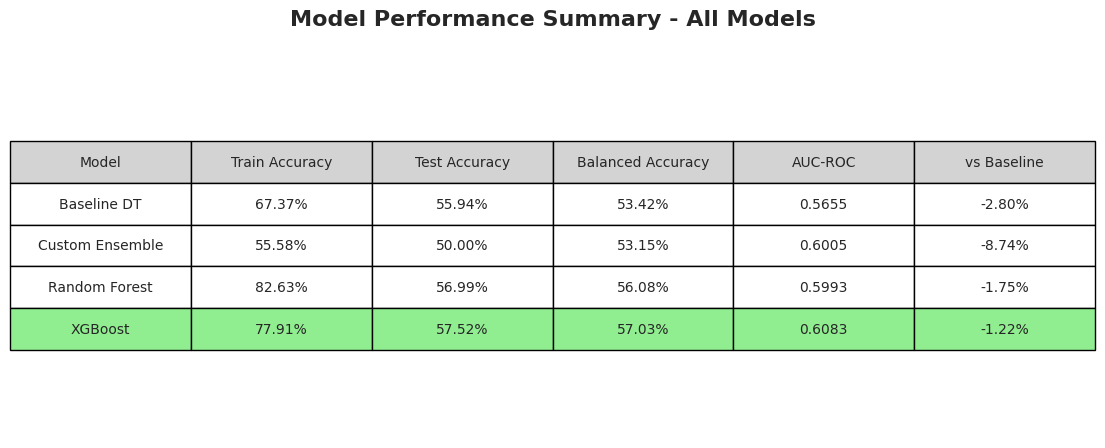


📊 VISUALIZATION COMPLETE!

Created visualizations:
1. decision_tree_structure.png - Baseline tree structure (top 3 levels)
2. feature_importance_comparison.html - Interactive feature comparison (RF & XGBoost)
3. performance_dashboard.html - Interactive performance metrics (all 4 models)
4. prediction_analysis.png - Prediction quality analysis (XGBoost)
5. feature_correlation_heatmap.png - Feature relationships (top 20)
6. elo_impact_analysis.png - ELO predictive power
7. model_summary_table.png - Performance comparison table (all 4 models)

📁 All saved to: /content/drive/MyDrive/UFC_ML_Project/visualizations/

🔍 KEY INSIGHTS:
• Best Model: XGBoost (57.52% test accuracy)
• Baseline Accuracy: 58.74% (always predict Red)
• Best Model vs Baseline: -1.22%
• Top Feature (XGBoost): diff_TD_landed
• High Confidence (>65%) Predictions: 56 fights (9.8%)
• High Confidence Accuracy: 78.57%
• XGBoost Overfitting Gap: 20.39% (Overfitting detected)


In [27]:
# ============================================================================
# COMPREHENSIVE MODEL VISUALIZATION (ALL 4 MODELS)
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib.patches import Patch

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print("📊 Creating comprehensive visualizations...\n")

# ============================================================================
# 1. DECISION TREE VISUALIZATION (Baseline)
# ============================================================================

print("1️⃣ Decision Tree Structure...")

fig, ax = plt.subplots(figsize=(25, 15))
plot_tree(
    dt_baseline,
    max_depth=3,  # Only show top 3 levels
    feature_names=all_features,
    class_names=['Blue Wins', 'Red Wins'],
    filled=True,
    rounded=True,
    fontsize=10,
    ax=ax
)
plt.title('Baseline Decision Tree Structure (Top 3 Levels)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/decision_tree_structure.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: decision_tree_structure.png")
plt.show()

# ============================================================================
# 2. FEATURE IMPORTANCE COMPARISON (RF & XGBoost only)
# ============================================================================

print("\n2️⃣ Feature Importance Across Models...")

# Top 15 features
top_n = 15

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=('Random Forest', 'XGBoost'),
    horizontal_spacing=0.15
)

# Random Forest
rf_top = rf_feature_importance.head(top_n)
fig.add_trace(
    go.Bar(
        y=rf_top['feature'][::-1],
        x=rf_top['importance'][::-1],
        orientation='h',
        marker_color='coral',
        name='Random Forest'
    ),
    row=1, col=1
)

# XGBoost
xgb_top = xgb_feature_importance.head(top_n)
fig.add_trace(
    go.Bar(
        y=xgb_top['feature'][::-1],
        x=xgb_top['importance'][::-1],
        orientation='h',
        marker_color='mediumseagreen',
        name='XGBoost'
    ),
    row=1, col=2
)

fig.update_layout(
    title_text=f'Top {top_n} Features by Model',
    showlegend=False,
    height=600,
    width=1400
)

fig.update_xaxes(title_text="Importance")

fig.write_html(f'{VIZ_PATH}/feature_importance_comparison.html')
print(f"   ✅ Saved: feature_importance_comparison.html")
fig.show()

# ============================================================================
# 3. MODEL PERFORMANCE METRICS (ALL 4 MODELS)
# ============================================================================

print("\n3️⃣ Model Performance Dashboard...")

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Accuracy Comparison (All Models)',
        'ROC Curves (Tree Models)',
        'XGBoost Confidence Distribution',
        'XGBoost Confusion Matrix'
    ),
    specs=[
        [{'type': 'bar'}, {'type': 'scatter'}],
        [{'type': 'histogram'}, {'type': 'heatmap'}]
    ]
)

# 3.1 Accuracy Comparison (All 4 models)
models_list = ['Baseline DT', 'Custom Ensemble', 'Random Forest', 'XGBoost']
train_accs = [dt_train_acc, ensemble_train_acc, rf_train_acc, xgb_train_acc]
test_accs = [dt_test_acc, ensemble_test_acc, rf_test_acc, xgb_test_acc]

fig.add_trace(
    go.Bar(name='Training', x=models_list, y=train_accs, marker_color='lightblue'),
    row=1, col=1
)
fig.add_trace(
    go.Bar(name='Test', x=models_list, y=test_accs, marker_color='darkblue'),
    row=1, col=1
)

# Add baseline reference line
fig.add_hline(y=baseline_accuracy, line_dash="dash", line_color="red",
              annotation_text=f"Baseline: {baseline_accuracy:.1%}",
              row=1, col=1)

# 3.2 ROC Curves (only for tree models - ensemble might not have probabilities)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb_test)

fig.add_trace(
    go.Scatter(x=fpr_dt, y=tpr_dt, name=f'Baseline DT (AUC={dt_auc:.3f})', mode='lines'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=fpr_rf, y=tpr_rf, name=f'RF (AUC={rf_auc:.3f})', mode='lines'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=fpr_xgb, y=tpr_xgb, name=f'XGB (AUC={xgb_auc:.3f})', mode='lines'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=[0, 1], y=[0, 1], name='Random', mode='lines',
               line=dict(dash='dash', color='gray')),
    row=1, col=2
)

# 3.3 Confidence Distribution (XGBoost)
confidence_xgb = np.max(xgb_model.predict_proba(X_test), axis=1)
fig.add_trace(
    go.Histogram(x=confidence_xgb, nbinsx=30, name='XGBoost Confidence', marker_color='green'),
    row=2, col=1
)

# 3.4 Best Model Confusion Matrix (XGBoost)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_test)
fig.add_trace(
    go.Heatmap(
        z=cm_xgb,
        x=['Blue Wins', 'Red Wins'],
        y=['Blue Wins', 'Red Wins'],
        colorscale='Blues',
        showscale=True,
        text=cm_xgb,
        texttemplate="%{text}",
        textfont={"size": 16}
    ),
    row=2, col=2
)

fig.update_layout(height=1000, width=1600, title_text="Model Performance Dashboard (All Models)")
fig.write_html(f'{VIZ_PATH}/performance_dashboard.html')
print(f"   ✅ Saved: performance_dashboard.html")
fig.show()

# ============================================================================
# 4. PREDICTION ANALYSIS (XGBoost - Best Model)
# ============================================================================

print("\n4️⃣ Prediction Analysis (XGBoost)...")

# Create prediction dataframe
pred_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_xgb_test,
    'prob_red': y_proba_xgb_test,
    'prob_blue': 1 - y_proba_xgb_test,
    'confidence': confidence_xgb,
    'correct': (y_test.values == y_pred_xgb_test).astype(int)
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 4.1 Accuracy by Confidence Level
confidence_bins = pd.cut(pred_df['confidence'], bins=[0, 0.55, 0.60, 0.65, 0.70, 1.0],
                         labels=['50-55%', '55-60%', '60-65%', '65-70%', '70-100%'])
acc_by_conf = pred_df.groupby(confidence_bins, observed=True)['correct'].agg(['mean', 'count'])

# Only plot bins with data
valid_bins = acc_by_conf[acc_by_conf['count'] > 0]
if len(valid_bins) > 0:
    axes[0, 0].bar(range(len(valid_bins)), valid_bins['mean'],
                   color='steelblue', alpha=0.8, edgecolor='black')
    axes[0, 0].axhline(0.5, color='red', linestyle='--', linewidth=2, label='Baseline (50%)')
    axes[0, 0].set_xticks(range(len(valid_bins)))
    axes[0, 0].set_xticklabels(valid_bins.index, rotation=0)
    axes[0, 0].set_xlabel('Confidence Level', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy', fontsize=12)
    axes[0, 0].set_title('Accuracy by Confidence Level (XGBoost)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim([0, 1])

    # Add count labels
    for i, (idx, row) in enumerate(valid_bins.iterrows()):
        axes[0, 0].text(i, row['mean'] + 0.02, f"{row['mean']:.1%}\n(n={int(row['count'])})",
                        ha='center', va='bottom', fontsize=9, fontweight='bold')
else:
    axes[0, 0].text(0.5, 0.5, 'No high confidence predictions',
                    ha='center', va='center', transform=axes[0, 0].transAxes, fontsize=12)

# 4.2 Probability Distribution
axes[0, 1].hist(pred_df['prob_red'], bins=30, alpha=0.7, color='red',
                label='Red Win Probability', edgecolor='black')
axes[0, 1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='50% threshold')
axes[0, 1].set_xlabel('Predicted Probability (Red Win)', fontsize=12)
axes[0, 1].set_ylabel('Number of Predictions', fontsize=12)
axes[0, 1].set_title('Distribution of Win Probabilities', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 4.3 Correct vs Incorrect Predictions by Confidence
correct_conf = pred_df[pred_df['correct'] == 1]['confidence']
incorrect_conf = pred_df[pred_df['correct'] == 0]['confidence']

axes[1, 0].hist([correct_conf, incorrect_conf], bins=20,
                label=['Correct', 'Incorrect'],
                color=['green', 'red'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Confidence', fontsize=12)
axes[1, 0].set_ylabel('Count', fontsize=12)
axes[1, 0].set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4.4 Calibration Plot
prob_bins = np.linspace(0, 1, 11)
bin_centers = (prob_bins[:-1] + prob_bins[1:]) / 2
binned_probs = pd.cut(pred_df['prob_red'], bins=prob_bins)
calibration = pred_df.groupby(binned_probs, observed=True)['actual'].mean()

# Remove NaN values
valid_calibration = calibration.dropna()
valid_centers = [bin_centers[i] for i in range(len(calibration)) if not pd.isna(calibration.iloc[i])]

if len(valid_calibration) > 0:
    axes[1, 1].plot(valid_centers, valid_calibration.values, 'o-', linewidth=2, markersize=8,
                    color='steelblue', label='XGBoost')
axes[1, 1].plot([0, 1], [0, 1], '--', color='gray', linewidth=2, label='Perfect Calibration')
axes[1, 1].set_xlabel('Predicted Probability', fontsize=12)
axes[1, 1].set_ylabel('Actual Fraction of Red Wins', fontsize=12)
axes[1, 1].set_title('Calibration Plot', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 1])
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/prediction_analysis.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: prediction_analysis.png")
plt.show()

# ============================================================================
# 5. FEATURE CORRELATION HEATMAP
# ============================================================================

print("\n5️⃣ Feature Correlation Analysis...")

# Get top 20 most important features from XGBoost
top_features = xgb_feature_importance.head(20)['feature'].tolist()
top_features_data = X_test[top_features]

# Calculate correlation
correlation_matrix = top_features_data.corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
plt.title('Feature Correlation Matrix (Top 20 Features - XGBoost)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: feature_correlation_heatmap.png")
plt.show()

# ============================================================================
# 6. ELO IMPACT VISUALIZATION (FIXED)
# ============================================================================

print("\n6️⃣ ELO Impact Analysis...")

# Get ELO difference and outcomes from test set
test_indices = X_test.index
elo_diff_test = data.loc[test_indices, 'elo_diff']
red_won_test = data.loc[test_indices, 'red_won']

# Create 15 bins (fewer bins to ensure enough data per bin)
elo_bins = pd.cut(elo_diff_test, bins=15)
win_rate = red_won_test.groupby(elo_bins, observed=True).mean()
fight_counts = red_won_test.groupby(elo_bins, observed=True).size()

# Remove empty bins
valid_mask = fight_counts > 0
win_rate = win_rate[valid_mask]
fight_counts = fight_counts[valid_mask]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Get bin centers for valid bins only
bin_centers = [interval.mid for interval in win_rate.index]

# Win rate by ELO difference
if len(bin_centers) > 0 and len(win_rate) > 0:
    ax1.plot(bin_centers, win_rate.values, marker='o', linewidth=2, markersize=8, color='steelblue')
    ax1.axhline(0.5, color='red', linestyle='--', linewidth=2, label='50% (Even Match)')

    # Create shaded regions
    x_smooth = np.array(bin_centers)
    y_smooth = np.array(win_rate.values)

    # Green for red advantage (above 50%)
    ax1.fill_between(x_smooth, 0.5, y_smooth, where=(y_smooth >= 0.5),
                      alpha=0.3, color='green', interpolate=True, label='Red Advantage')
    # Blue for blue advantage (below 50%)
    ax1.fill_between(x_smooth, y_smooth, 0.5, where=(y_smooth < 0.5),
                      alpha=0.3, color='blue', interpolate=True, label='Blue Advantage')

    ax1.set_xlabel('ELO Difference (Red - Blue)', fontsize=12)
    ax1.set_ylabel('Red Fighter Win Rate', fontsize=12)
    ax1.set_title('Win Rate by ELO Difference (Test Set)', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

    # Number of fights per ELO bin
    if len(bin_centers) > 1:
        bar_width = (max(bin_centers) - min(bin_centers)) / len(bin_centers) * 0.8
    else:
        bar_width = 10

    ax2.bar(bin_centers, fight_counts.values, width=bar_width,
            color='coral', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('ELO Difference (Red - Blue)', fontsize=12)
    ax2.set_ylabel('Number of Fights', fontsize=12)
    ax2.set_title('Fight Distribution by ELO Difference', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
else:
    ax1.text(0.5, 0.5, 'Insufficient data for ELO analysis',
            ha='center', va='center', transform=ax1.transAxes, fontsize=14)
    ax2.text(0.5, 0.5, 'Insufficient data for ELO analysis',
            ha='center', va='center', transform=ax2.transAxes, fontsize=14)

plt.tight_layout()
plt.savefig(f'{VIZ_PATH}/elo_impact_analysis.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: elo_impact_analysis.png")
plt.show()

# ============================================================================
# 7. MODEL COMPARISON SUMMARY TABLE
# ============================================================================

print("\n7️⃣ Creating Model Comparison Summary...")

# Summary statistics (all 4 models)
summary_data = {
    'Model': models,
    'Train Accuracy': [f'{acc:.2%}' for acc in train_accuracies],
    'Test Accuracy': [f'{acc:.2%}' for acc in test_accuracies],
    'Balanced Accuracy': [f'{acc:.2%}' for acc in balanced_accuracies],
    'AUC-ROC': [f'{auc:.4f}' for auc in auc_scores],
    'vs Baseline': [f'{(acc - baseline_accuracy)*100:+.2f}%' for acc in test_accuracies]
}

summary_df = pd.DataFrame(summary_data)

fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center',
    colColours=['lightgray']*len(summary_df.columns)
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Highlight best model
best_idx_table = test_accuracies.index(max(test_accuracies))
best_row = best_idx_table + 1
for col in range(len(summary_df.columns)):
    table[(best_row, col)].set_facecolor('#90EE90')

plt.title('Model Performance Summary - All Models', fontsize=16, fontweight='bold', pad=20)
plt.savefig(f'{VIZ_PATH}/model_summary_table.png', dpi=300, bbox_inches='tight')
print(f"   ✅ Saved: model_summary_table.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*80)
print("📊 VISUALIZATION COMPLETE!")
print("="*80)
print(f"\nCreated visualizations:")
print(f"1. decision_tree_structure.png - Baseline tree structure (top 3 levels)")
print(f"2. feature_importance_comparison.html - Interactive feature comparison (RF & XGBoost)")
print(f"3. performance_dashboard.html - Interactive performance metrics (all 4 models)")
print(f"4. prediction_analysis.png - Prediction quality analysis (XGBoost)")
print(f"5. feature_correlation_heatmap.png - Feature relationships (top 20)")
print(f"6. elo_impact_analysis.png - ELO predictive power")
print(f"7. model_summary_table.png - Performance comparison table (all 4 models)")
print(f"\n📁 All saved to: {VIZ_PATH}/")
print("="*80)

# Print key insights
print("\n🔍 KEY INSIGHTS:")
print(f"• Best Model: {best_model_name} ({best_accuracy:.2%} test accuracy)")
print(f"• Baseline Accuracy: {baseline_accuracy:.2%} (always predict Red)")
print(f"• Best Model vs Baseline: {(best_accuracy - baseline_accuracy)*100:+.2f}%")
print(f"• Top Feature (XGBoost): {xgb_feature_importance.iloc[0]['feature']}")

# High confidence accuracy (if any exist)
high_conf = pred_df[pred_df['confidence'] > 0.65]
if len(high_conf) > 0:
    print(f"• High Confidence (>65%) Predictions: {len(high_conf)} fights ({len(high_conf)/len(pred_df)*100:.1f}%)")
    print(f"• High Confidence Accuracy: {high_conf['correct'].mean():.2%}")
else:
    print(f"• High Confidence (>65%) Predictions: None (model lacks confidence)")

# Overfitting check
overfitting_gap = xgb_train_acc - xgb_test_acc
print(f"• XGBoost Overfitting Gap: {overfitting_gap*100:.2f}% ({'Good' if overfitting_gap < 0.1 else 'Overfitting detected'})")
print("="*80)